## Introduction

For this dataset we will do a lot of Feature Engineering and will also have a baseline line model, i.e Linear Regression. This model will give us the worse case scenerio of our data and will be improved on with better models.

The model will be trained on the train set and be tested on the test set. Metrics such as RMSE, Mean Squared, etc. will be used to validate the model.

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm,skew
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score,r2_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Functions

In [47]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [48]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [49]:
train_df.shape, test_df.shape

((1460, 81), (1459, 80))

The data has 81 features.
This features can be grouped into:
- Sale Price - Target
- Location of the house (including the neihbourhood)
- Sale Condition (including year sold or built)
- House Condition (including the type of rooms, measurements and condition of the room)

In [50]:
train_df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [51]:
test_df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64

Most of the columns don't have null values

In [52]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We will drop the Id column from both the test and train df since we won't be feeding it into our model.

In [53]:
train_ID = train_df['Id']
test_ID = test_df['Id']
train_df.drop("Id", axis = 1, inplace = True)
test_df.drop("Id", axis = 1, inplace = True)

## Exploratory Analysis

Our target variable is the SalePrice, let's analyse our target variable.

In [54]:
train_df.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

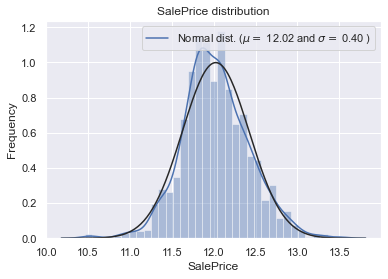

In [55]:
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])
 
sns.distplot(train_df['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(train_df['SalePrice'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution');

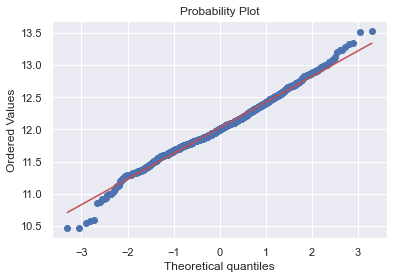

In [56]:
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

The minimum value is more than zero, hence that shows the price is a valid.
Also, the graph is a skewed one, it is positively skewed, hence is not a normal distribution. We will have to transform the variable to look like a normal distribution.

We will also chack its relationship with other numerical variables

Applying log transformation to correct the positive skewness in the data and taking logs means that errors in predicting expensive and cheap houses will affect the result equally.

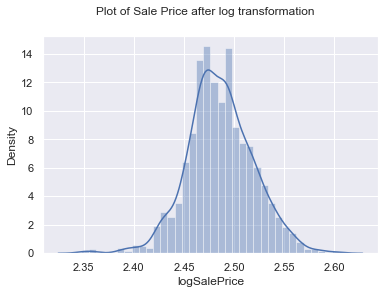

In [57]:
train_df['logSalePrice'] = np.log(train_df['SalePrice'])
plt.suptitle("Plot of Sale Price after log transformation")
sns.distplot(train_df['logSalePrice'])
plt.show()

In [58]:
train_df['SalePrice'].describe()

count    1460.000000
mean       12.024057
std         0.399449
min        10.460271
25%        11.775105
50%        12.001512
75%        12.273736
max        13.534474
Name: SalePrice, dtype: float64

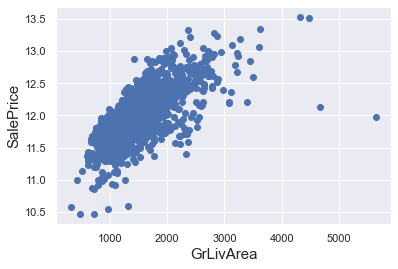

In [59]:
fig, ax = plt.subplots()
ax.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

From the above plot, the Living area and Sale Price have roughly a linear relationship. The two dots on the top indicate a sudden price increase. It may be because the house is located in a hot spot.

Also the last 2 points that do no follow the linear rule could be an indication of not so good land conditions. This points can be seen as outliers and should be removed before it is being fed into the model.

What can we say about it's relationship with the size of basement?

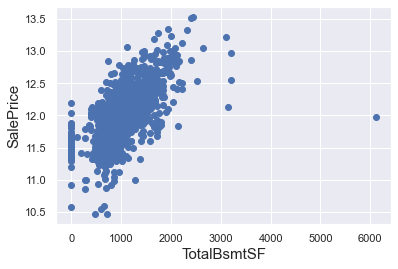

In [60]:
var = 'TotalBsmtSF'
fig, ax = plt.subplots()
ax.scatter(x = train_df[var], y = train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('TotalBsmtSF', fontsize=15)
plt.show();

There is a strong linear relationship between Sales Price and total square basement


Let's see SalePrice relationship with some categorical variables

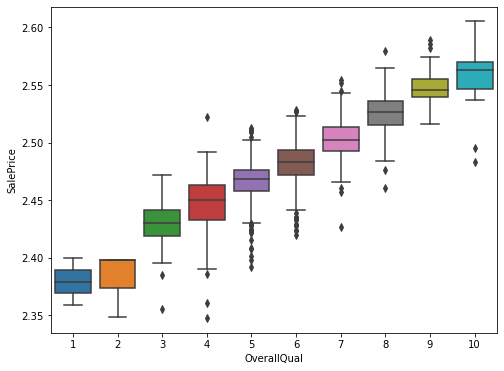

In [16]:
var = 'OverallQual'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)

There is a good relationship between the overall quality and sales price

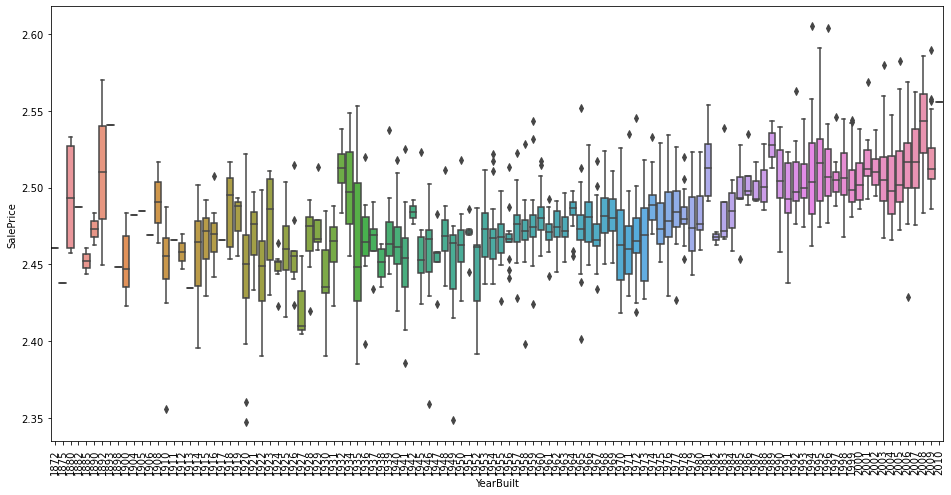

In [17]:
var = 'YearBuilt'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
plt.xticks(rotation=90);

Although, there is no strong relationship seen, but we can say that houses built in later years seem to have higher sales price.

We have analyses some variables that we think should affect the sale price, but there are a lot more of them and checking them one after the other might be time consuming, hence, let's see a correlation between these variables

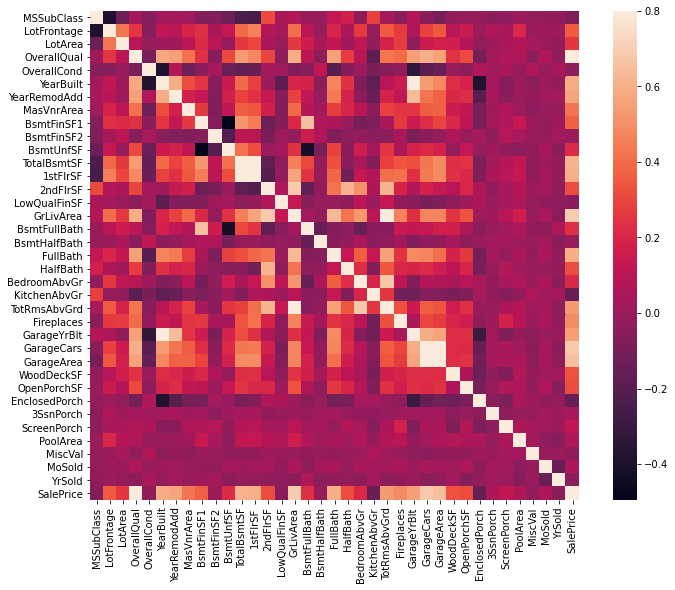

In [18]:
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

This shows us a good correlation matrix but can be really confusing to understand, hence, we will use smaller and zoomed out map.

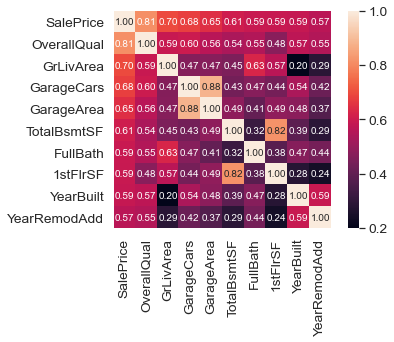

In [19]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

From the map above, 

'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'.

'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables. We can say that the number of cars that fit into the garage is a consequence of the garage area. Therefore, we just need one of these variables in our analysis (we can keep 'GarageCars' since its correlation with 'SalePrice' is higher).

'TotalBsmtSF' and '1stFloor' also seem to be highly correlated. We can keep 'TotalBsmtSF'.

'FullBath' is slightly correlated with sale price.

'TotRmsAbvGrd' and 'GrLivArea' are also highly correlated.

'YearBuilt' seems to also be slightly correlated with 'SalePrice'.


Now let's do a scatterplots of these correlated variables.

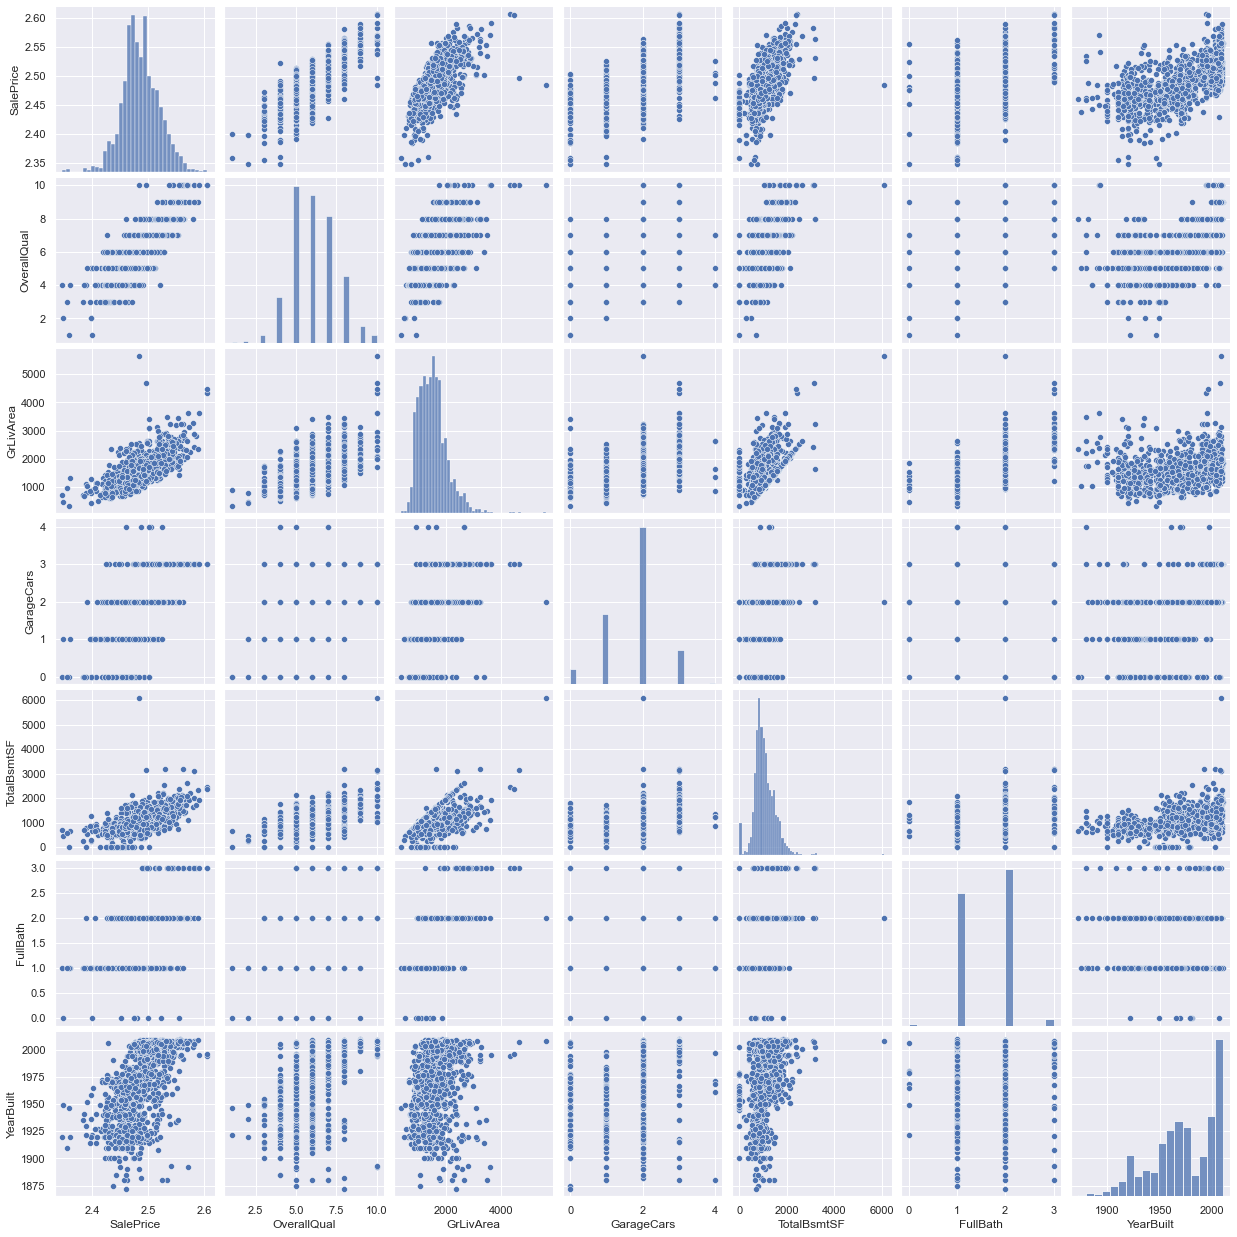

In [20]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train_df[cols], size = 2.5)
plt.show();

Some of these correlations are not new as we have seen them earlier.

### Handling missing values

In [21]:
ntrain = train_df.shape[0]
ntest = test_df.shape[0]
y_train = train_df.SalePrice.values
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


In [22]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(15)

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageFinish,5.447071
GarageYrBlt,5.447071
GarageQual,5.447071
GarageCond,5.447071


Looking at the top 5 variables, that have the most missing values, they don't seem so important in predicting the price of a house. But we will not drop them yet.

Let's fill all missing value with 0 or None

First, let's plot the missing values.

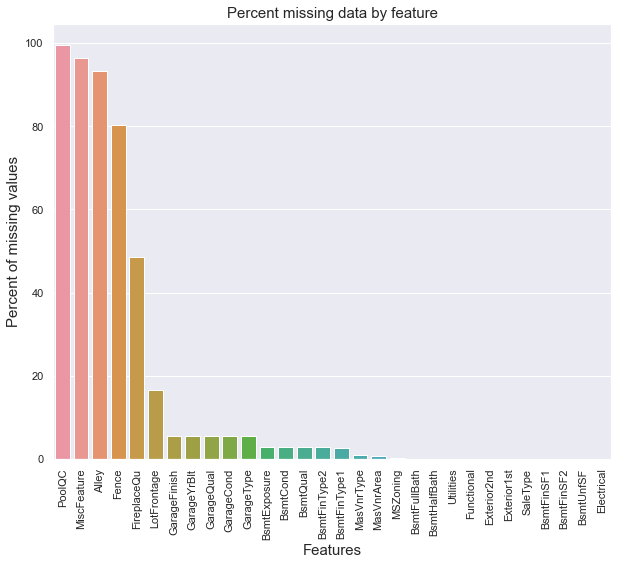

In [23]:
f, ax = plt.subplots(figsize=(10, 8))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15);

### Data Cleaning

Almost all the data is "AllPub", hence we will drop the utilities column as it doesn't add much to predicting the price.

We will also fill the nan values in the functional column with "Typ", since it's most frequent

In [61]:
def missing (df):
    
    # drop theses columns due to large null values or many same values
    df = df.drop(['Utilities','PoolQC','MiscFeature','Alley'], axis=1)
    
    # Null value likely means No Fence so fill as "None"
    df["Fence"] = df["Fence"].fillna("None") 
    
    # Null value likely means No Fireplace so fill as "None"
    df["FireplaceQu"] = df["FireplaceQu"].fillna("None")
    
    # Lot frontage is the feet of street connected to property, 
    #which is likely similar to the neighbourhood houses, so fill Median value
    df["LotFrontage"] = df["LotFrontage"].fillna(df["LotFrontage"].median())
    
    # Null value likely means  typical(Typ)
    df["Functional"] = df["Functional"].fillna("Typ")
    
    # Only one null value so fill as the most frequent value(mode)
    df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])  
    
    # Only one null value so fill as the most frequent value(mode)
    df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
    
    # Very few null value so fill with the most frequent value(mode)
    df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
    
    # Null value likely means no masonry veneer
    df["MasVnrType"] = df["MasVnrType"].fillna("None") #so fill as "None" (since categorical feature)
    df["MasVnrArea"] = df["MasVnrArea"].fillna(0)      #so fill as o
    
    # Only one null value so fill as the most frequent value(mode)
    df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
    df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
    
    #MSZoning is general zoning classification,Very few null value so fill with the most frequent value(mode)
    df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
    
    #Null value likely means no Identified type of dwelling so fill as "None"
    df['MSSubClass'] = df['MSSubClass'].fillna("None")
    
    # Null value likely means No Garage, so fill as "None" (since these are categorical features)
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
        df[col] = df[col].fillna('None')
    
    # Null value likely means No Garage and no cars in garage, so fill as 0
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        df[col] = df[col].fillna(0)
    
    # Null value likely means No Basement, so fill as 0
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        df[col] = df[col].fillna(0)
    
    # Null value likely means No Basement, so fill as "None" (since these are categorical features)
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        df[col] = df[col].fillna('None')
    
    return df

df_train = missing(train_df)
df_test = missing(test_df)

In [63]:
# calculate total number of null values in training data
null_train = df_train.isnull().sum().sum()
print(null_train)

# calculate total number of null values in test data
null_test = df_test.isnull().sum().sum()
print(null_test)

0
0


In [64]:
df_train.shape,df_test.shape

((1460, 77), (1459, 75))

We've taken care of all missing values.

We will change all objects to string for easy modelling

#### Creating new features with existing features

In [65]:
def add_new_cols(df):
    
    df['Total_SF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

    df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] 
                             + (0.5 * df['BsmtHalfBath']))

    df['Total_Porch_SF'] = (df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + 
                            df['ScreenPorch'] + df['WoodDeckSF'])

    df['Total_Square_Feet'] = (df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF'])
    
    df['Total_Quality'] = df['OverallQual'] + df['OverallCond']
    
    return df

In [66]:
df_train = add_new_cols(df_train)
df_test = add_new_cols(df_test)

In [68]:
df_train.shape,df_test.shape

((1460, 82), (1459, 80))

#### Check data types

In [69]:
group1 = df_train.columns.to_series().groupby(df_train.dtypes).groups

In [70]:
{k.name: v for k, v in group1.items()}

{'int64': Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
        'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
        '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
        'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
        'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
        'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
        'MiscVal', 'MoSold', 'YrSold', 'Total_SF', 'Total_Porch_SF',
        'Total_Square_Feet', 'Total_Quality'],
       dtype='object'),
 'float64': Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'SalePrice', 'logSalePrice',
        'Total_Bathrooms'],
       dtype='object'),
 'object': Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig',
        'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
        'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',


In [71]:
group2 = df_test.columns.to_series().groupby(df_test.dtypes).groups

In [72]:
{k.name: v for k, v in group2.items()}

{'int64': Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
        'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
        'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
        'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',
        'Total_Porch_SF', 'Total_Quality'],
       dtype='object'),
 'float64': Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
        'GarageCars', 'GarageArea', 'Total_SF', 'Total_Bathrooms',
        'Total_Square_Feet'],
       dtype='object'),
 'object': Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig',
        'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
        'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
        'MasVnrType', 'ExterQ

### Bivariate Analysis

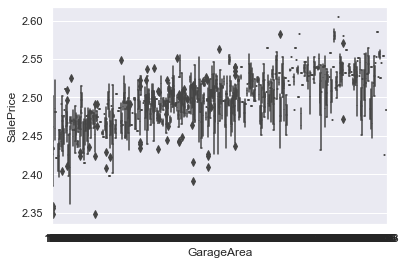

In [35]:
sns.boxplot(y='SalePrice', x = 'GarageArea', data=df_train);

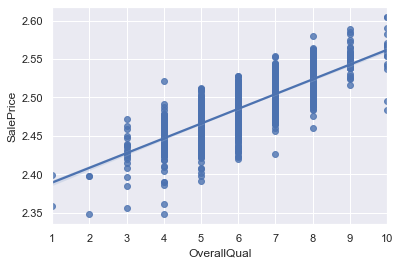

In [36]:
sns.regplot(x='OverallQual', y='SalePrice', data=df_train, robust=True);

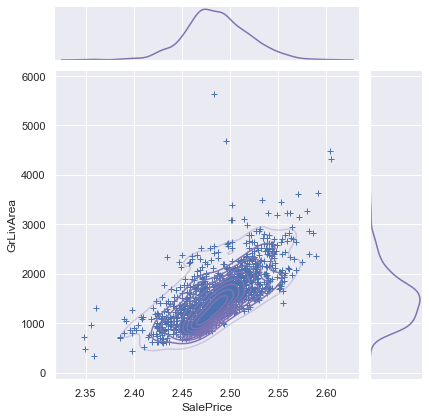

In [37]:
g = sns.jointplot(x='SalePrice', y='GrLivArea', data=df_train, kind='kde', color='m')
g.plot_joint(plt.scatter, color='b', s=40, linewidth=1, marker='+' )
g.ax_joint.collections[0].set_alpha(0.3)

### Multivariate analysis

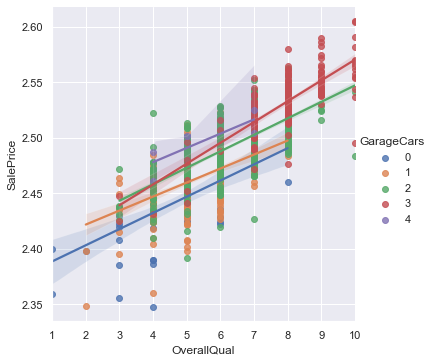

In [38]:
sns.lmplot(x='OverallQual', y='SalePrice', data=df_train, hue= 'GarageCars');

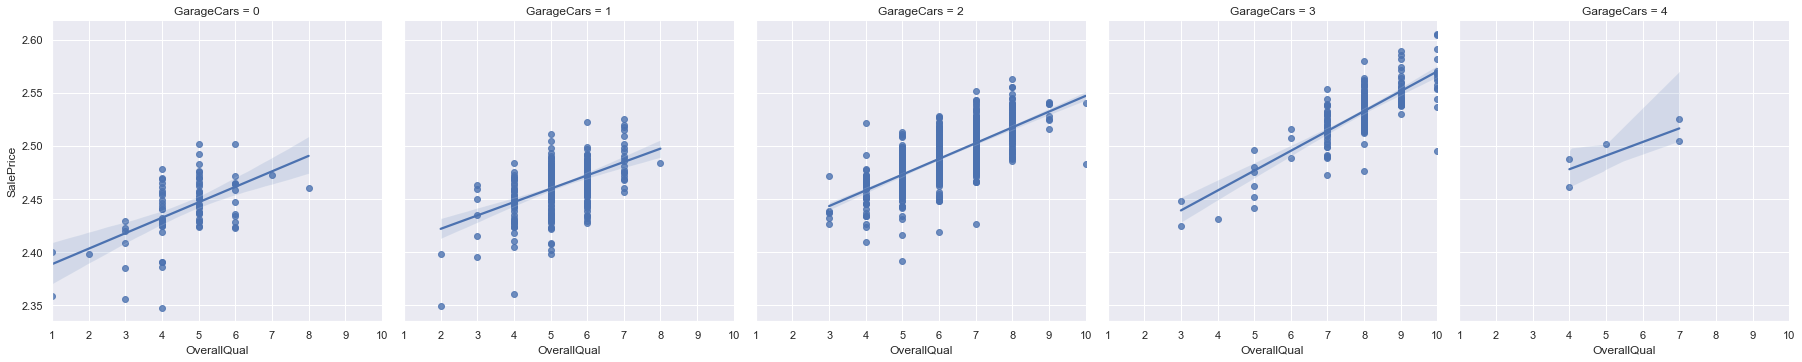

In [39]:
sns.lmplot(x='OverallQual', y='SalePrice', data=df_train, col= 'GarageCars');

### Modeling

In [76]:
y_train = df_train['SalePrice']
df_train = pd.get_dummies(df_train.drop(['SalePrice','logSalePrice'],axis=1))
df_test = pd.get_dummies(df_test)

print(df_train.shape)
print(df_test.shape)

(1460, 293)
(1459, 278)


In [77]:
df_train, df_test = df_train.align(df_test, join = 'inner', axis=1)

In [78]:
print(df_train.shape)
print(df_test.shape)

(1460, 278)
(1459, 278)


In [79]:
null_train = df_train.isnull().sum().sum()
print(null_train)

null_test = df_test.isnull().sum().sum()
print(null_test)

0
0


In [80]:
df_train['SalePrice'] = y_train

In [44]:
df_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0


In [81]:
train_set, valid_set = train_test_split(df_train,train_size= 0.7, shuffle=False)

X_train = train_set.drop(["SalePrice"], axis=1)
y_train = train_set["SalePrice"].copy()       

X_valid = valid_set.drop(["SalePrice"], axis=1) 
y_valid = valid_set["SalePrice"].copy()  

In [83]:
X_test = df_test 

In [84]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print()
print("X_valid shape: {}".format(X_valid.shape))
print("y_valid shape: {}".format(y_valid.shape))
print()
print("X_test shape: {}".format(X_test.shape))

X_train shape: (1021, 278)
y_train shape: (1021,)

X_valid shape: (439, 278)
y_valid shape: (439,)

X_test shape: (1459, 278)


In [90]:
# function to calculate Root mean square error (RMSE)
def rmse(y_pred, y_train): 
    
    rmse_ = np.sqrt(mean_squared_error(y_pred,y_train))
    print("rmse: ", rmse_)

In [86]:
# function to plot actual vs predicited label
def actual_vs_pred_plot(y_train,y_pred):
    
    fig = plt.figure(figsize=(12,12))
    fig, ax = plt.subplots()
    
    ax.scatter(y_train, y_pred,color = "teal",edgecolor = 'lightblue')
    ax.plot([y_train.min(),y_train.max()], [y_train.min(), y_train.max()], 'k--',lw=0.2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    plt.suptitle("Actual vs Predicted Scatter Plot",size=14)
    plt.show()

### Models

In [106]:
reg = LinearRegression()

In [91]:
#fit on training
model_reg = reg.fit(X_train, y_train)

#predict value of sale price on the training set
y1_pred = reg.predict(X_train)

#caculate root mean square error
rmse(y1_pred,y_train)

rmse:  0.09466059362250538


In [92]:
#predict value of sale price on the validation set
y1_pred_v = reg.predict(X_valid)

#caculate root mean square error
rmse(y1_pred_v, y_valid)

rmse:  0.17857244247207446


<Figure size 864x864 with 0 Axes>

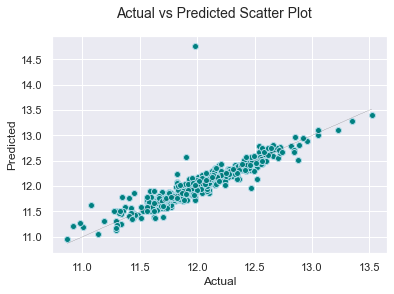

In [94]:
actual_vs_pred_plot(y_valid,y1_pred_v);

### Random Forest

In [171]:
rforest = RandomForestRegressor(n_estimators=250, max_depth=10, min_samples_leaf=3,random_state=42)

In [172]:
#fit
model_rforest = rforest.fit(X_train, y_train)

#predict value of sale price on the training set
y1_pred = rforest.predict(X_train)

#caculate root mean square error
rmse(y1_pred,y_train)

rmse:  0.07658595609523332


In [173]:
#predict value of sale price on the validation set
y1_pred_v = rforest.predict(X_valid)

#caculate root mean square error
rmse(y1_pred_v, y_valid)

rmse:  0.14409978035116983


<Figure size 864x864 with 0 Axes>

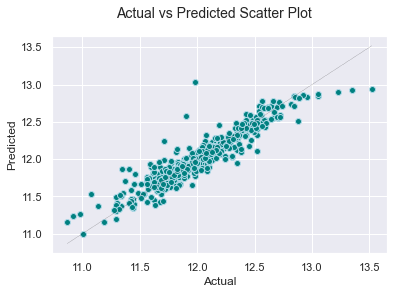

In [174]:
#plot
actual_vs_pred_plot(y_valid, y1_pred_v);

### Conclusion

In conclusion, we can say that Random Forest performs better. Although, some other models could perform better but we will be limiting ourselves to these 2 for the sake of this project.